In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

from stellargraph import datasets
from IPython.display import display, HTML

***Links***
* GraphSAGE Unsupervised - https://stellargraph.readthedocs.io/en/stable/demos/embeddings/graphsage-unsupervised-sampler-embeddings.html

In [3]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [4]:
nodes = list(G.nodes())
number_of_walks = 1
length = 5

In [5]:
unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length=length, number_of_walks=number_of_walks
)

In [6]:
batch_size = 50
epochs = 4
num_samples = [10, 5]

In [7]:
generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)

In [8]:
layer_sizes = [50, 50]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)

In [9]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [10]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

/home/vscode/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Epoch 1/4
434/434 [==============================] - 114s 251ms/step - loss: 0.5685 - binary_accuracy: 0.7388
Epoch 2/4
434/434 [==============================] - 118s 244ms/step - loss: 0.5420 - binary_accuracy: 0.7696
Epoch 3/4
434/434 [==============================] - 99s 227ms/step - loss: 0.5370 - binary_accuracy: 0.7785
Epoch 4/4
434/434 [==============================] - 116s 265ms/step - loss: 0.5358 - binary_accuracy: 0.7853


In [12]:
# extracting node embeddings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [14]:
node_ids = node_subjects.index
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(node_ids)

In [15]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

55/55 [==============================] - 10s 132ms/step


In [16]:
node_subject = node_subjects.astype("category").cat.codes

X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
    emb_transformed["label"] = node_subject
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = node_subject

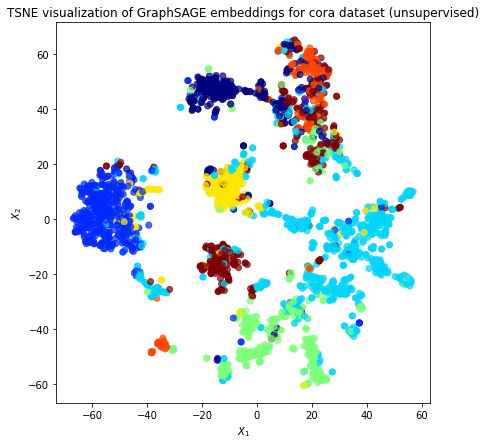

In [25]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset (unsupervised)".format(transform.__name__)
)
plt.show()

In [27]:
test_gen = generator.flow(test_subjects.index, test_targets)

test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

NameError: name 'test_subjects' is not defined